In [ ]:
import pandas as pd
import math

In [1]:
grampa_path = 'data/origin_data/grampa.csv'
negative_file_path = 'data/origin_data/origin_negative.csv'

### Generate Sample Class

Class that implements the filtering from the papers code base

In [2]:
class GenerateSample():
    def __init__(self, grampa_path, negative_file_path):
        self.grampa_path = grampa_path
        self.negative_file_path = negative_file_path
        self.positive_samples = None
        self.negative_samples = None
        self.all_samples = None

    def __call__(self, *args, **kwargs):
        grampa_data = pd.read_csv(self.grampa_path, encoding="utf8")
        grampa_data = self.filter_data_with_str("bacterium", "aureus", grampa_data)
        self.positive_samples = self.generate_all_peptides(grampa_data)
        self.negative_samples = self.generate_negative_data(self.negative_file_path)
        self.all_samples = self.concat_datasets(self.positive_samples, self.negative_samples)
        

    def filter_data_with_str(self, col_name, str, data):

        bool_filter = data[col_name].str.contains(str)
        filter_data = data[bool_filter]
        return filter_data

    def generate_all_peptides(self, data):

        data_all = [[], [], []]
        for i in data["sequence"].unique():
            data_all[0].append(i)
            log_num = 0
            count = 0
            for i in data[data["sequence"] == i]["value"]:
                log_num += math.pow(10, i)
                count += 1
            data_all[1].append(float(log_num / count))
            data_all[2].append(1)

        data_all = list(map(list, zip(*data_all)))
        data = pd.DataFrame(data=data_all, columns=["sequence", "MIC", "type"])
        return data

    def data2csv(self, data, file_name):

        data.to_csv(file_name, encoding="utf8", index=False)

    def generate_negative_data(self, negative_file_path):

        data_negative = pd.read_csv(negative_file_path, encoding="utf8")
        # removes entries with unknown and uncommon amino acid identifiers
        data_negative = data_negative[~data_negative["Sequence"].str.contains("B|X|Z|O|U")]
        data_negative.reset_index(drop=True, inplace=True)
        data = data_negative.rename(columns={'Sequence': 'sequence'}).assign(MIC=8196).assign(type=0)[['sequence', 'MIC', 'type']]

        return data


    def concat_datasets(self, positive_file, negative_file):

        data_concat = pd.concat([positive_file, negative_file], ignore_index=True, axis=0)  # 默认纵向合并0 横向合并1
        data_concat = data_concat.sample(frac=1,random_state=None)
        data_concat.reset_index(drop=True, inplace=True)
        return data_concat

    def split_sample(self, sample):
        num = len(sample)
        train_sample = sample[:int(0.8 * num)]
        test_sample = sample[int(0.8 * num):]
        self.data2csv(train_sample, self.generate_example_path + "regression_train_sample.csv")
        self.data2csv(test_sample, self.generate_example_path + "regression_test_sample.csv")


### Generating samples according to papers library

In [4]:
samples = GenerateSample(grampa_path, negative_file_path)
samples()

In [5]:
x = [samples.positive_samples,
samples.negative_samples,
samples.all_samples]
label = ['positive_samples', 'negative_samples', 'all_samples']
print('Using the code from the paper we get the following amount of data.')
for i, l in zip(x, label):
    print('-'*50)
    print(l)
    print(len(i))

Using the code from the paper we get the following amount of data.
--------------------------------------------------
positive_samples
4582
--------------------------------------------------
negative_samples
8047
--------------------------------------------------
all_samples
12629


# Making negative examples from UniProt Database

## Processing

In [32]:
data_negative = pd.read_csv(negative_file_path, encoding="utf8").rename(columns={'Protein names': 'protein_names'})
print(f'Original Negative data: {len(data_negative)}')

Original Negative data: 8556


In [33]:
print(data_negative.describe())
print(data_negative.info())

            Length
count  8556.000000
mean     25.168887
std      11.024466
min       2.000000
25%      14.000000
50%      28.000000
75%      36.000000
max      40.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8556 entries, 0 to 8555
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Entry          8556 non-null   object
 1   Status         8556 non-null   object
 2   protein_names  8556 non-null   object
 3   Organism       8556 non-null   object
 4   Length         8556 non-null   int64 
 5   Keywords       8455 non-null   object
 6   Sequence       8556 non-null   object
 7   Features       8556 non-null   object
dtypes: int64(1), object(7)
memory usage: 534.9+ KB
None


## Remove unknown amino acids

In [34]:
data_negative = data_negative[~data_negative["Sequence"].str.contains("B|X|Z|O|U")]
data_negative.reset_index(drop=True, inplace=True)

In [35]:
data_negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8047 entries, 0 to 8046
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Entry          8047 non-null   object
 1   Status         8047 non-null   object
 2   protein_names  8047 non-null   object
 3   Organism       8047 non-null   object
 4   Length         8047 non-null   int64 
 5   Keywords       7947 non-null   object
 6   Sequence       8047 non-null   object
 7   Features       8047 non-null   object
dtypes: int64(1), object(7)
memory usage: 503.1+ KB


## Assign MIC value to negative samples (Absurdly high MIC)

In [36]:
data = data_negative.rename(columns={'Sequence': 'sequence'})
data_filtered = data.groupby('sequence', as_index=False).agg({'sequence':'first'}).assign(MIC=8196).assign(type=0)[['sequence', 'MIC', 'type']]
data_filtered

sequence   MIC  type
0     AAAAPGAAGGAQLPLGNRERKAGCKNFFWKTFSSC  8196     0
1                         AAAAPPRRGPSGPDA  8196     0
2                     AAAELSLVQLESLREVCEQ  8196     0
3                              AAAGDNFMRF  8196     0
4     AAAISCVGSKECLPKCKAQGCKSGKCMNKKCKCYC  8196     0
...                                   ...   ...   ...
5910                       YYEEYVDGQGMVVR  8196     0
5911   YYICESCWTCESCAGSTESSCVSACNACDLCPNK  8196     0
5912                 YYTVLFGVSRALGLPLERPK  8196     0
5913                             YYVDLQNR  8196     0
5914     YYVWIGLRWVNIDCVEGNWSDYSSVSYENLVR  8196     0

[5915 rows x 3 columns]

## Filter by sequence length. Keep peptides between 0 - 40 AAs long

In [43]:
x = data_filtered.sequence.map(lambda x: True if 0 < len(x) else False)
data = data_filtered[x]

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5915 entries, 0 to 5914
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  5915 non-null   object
 1   MIC       5915 non-null   int64 
 2   type      5915 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 184.8+ KB


## Results

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5915 entries, 0 to 5914
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  5915 non-null   object
 1   MIC       5915 non-null   int64 
 2   type      5915 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 184.8+ KB


In [46]:
data.sequence.nunique()

5915

In [47]:
print('The paper reports 5,898 negative samples')

The paper reports 5,898 negative samples


In [48]:
print(len(data), 'NEGATIVE SAMPLES after filtering by sequence and amino acids.')

5915 NEGATIVE SAMPLES after filtering by sequence and amino acids.


In [49]:
data[['sequence', 'MIC']].to_csv('uniprot_negatives.csv')

In [50]:
acceptable_negative_sequences = data.sequence

In [51]:
negative_sequences = list(set(acceptable_negative_sequences.to_list()))

In [52]:
len(negative_sequences)

5915

In [80]:
import json
with open('/Users/hectorlopezhernandez/Dropbox/ML-Antimicrobial/ML-guided-polymer-design/data/literature_datasets/negative_sequences.json', 'w') as f:
    json.dump(negative_sequences, f)

# Making positive data

## Processing

In [97]:
grampa_data = pd.read_csv(grampa_path, encoding="utf8").drop('Unnamed: 0', axis=1)
grampa_data.head()

bacterium modifications                                    sequence  \
0     B. subtilis   [disulfide]                 GLPRKILCAIAKKKGKCKGPLKLVCKC   
1   S. agalactiae   [disulfide]  GFGCPGDAYQCSEHCRALGGGRTGGYCAGPWYLGHPTCTCSF   
2       S. aureus   [disulfide]  GFGCPGDAYQCSEHCRALGGGRTGGYCAGPWYLGHPTCTCSF   
3    S. pneumonia   [disulfide]  GFGCPGDAYQCSEHCRALGGGRTGGYCAGPWYLGHPTCTCSF   
4  S. epidermidis   [disulfide]  GFGCPGDAYQCSEHCRALGGGRTGGYCAGPWYLGHPTCTCSF   

      strain unit                                         url_source  \
0        NaN   uM  http://aps.unmc.edu/AP/database/query_output.p...   
1        NaN   uM  http://aps.unmc.edu/AP/database/query_output.p...   
2  ATCC29213   uM  http://aps.unmc.edu/AP/database/query_output.p...   
3  ATCC49619   uM  http://aps.unmc.edu/AP/database/query_output.p...   
4  ATCC12228   uM  http://aps.unmc.edu/AP/database/query_output.p...   

      value  is_modified  has_unusual_modification  has_cterminal_amidation  \
0 -0.397940         True                     False                    False   
1 -1.859819         True                     False                    False   
2  0.566150         True                     False                    False   
3 -1.240030         True                     False                    False   
4  0.566150         True                     False                    False   

   datasource_has_modifications database  
0                          True      APD  
1                          True      APD  
2                          True      APD  
3                          True      APD  
4                          True      APD

In [98]:
grampa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51345 entries, 0 to 51344
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bacterium                     51345 non-null  object 
 1   modifications                 51345 non-null  object 
 2   sequence                      51345 non-null  object 
 3   strain                        29111 non-null  object 
 4   unit                          51345 non-null  object 
 5   url_source                    51345 non-null  object 
 6   value                         51345 non-null  float64
 7   is_modified                   51345 non-null  bool   
 8   has_unusual_modification      51345 non-null  bool   
 9   has_cterminal_amidation       51345 non-null  bool   
 10  datasource_has_modifications  51345 non-null  bool   
 11  database                      51345 non-null  object 
dtypes: bool(4), float64(1), object(7)
memory usage: 3.3+ MB


## Filter by target aureus

In [99]:
col_name = "bacterium"
target = "aureus"

bool_filter = grampa_data[col_name].str.contains(target)
filter_data = grampa_data[bool_filter]

In [100]:
filter_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8955 entries, 2 to 51341
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bacterium                     8955 non-null   object 
 1   modifications                 8955 non-null   object 
 2   sequence                      8955 non-null   object 
 3   strain                        5209 non-null   object 
 4   unit                          8955 non-null   object 
 5   url_source                    8955 non-null   object 
 6   value                         8955 non-null   float64
 7   is_modified                   8955 non-null   bool   
 8   has_unusual_modification      8955 non-null   bool   
 9   has_cterminal_amidation       8955 non-null   bool   
 10  datasource_has_modifications  8955 non-null   bool   
 11  database                      8955 non-null   object 
dtypes: bool(4), float64(1), object(7)
memory usage: 664.6+ KB


data filtering on target aureus reduces data from 51345 to 8955 entries

In [101]:
filter_data.head()

bacterium modifications                                    sequence  \
2   S. aureus   [disulfide]  GFGCPGDAYQCSEHCRALGGGRTGGYCAGPWYLGHPTCTCSF   
7   S. aureus            []               LVKDNPLDISPKQVQALCTDLVIRCMCCC   
11  S. aureus            []                               YPELQQDLIARLL   
15  S. aureus   [disulfide]       GVFTLIKGATQLIGKTLGKELGKTGLELMACKITEQC   
19  S. aureus   [disulfide]                    FLPAIAGMAAKFLPKIFCAISKKC   

       strain unit                                         url_source  \
2   ATCC29213   uM  http://aps.unmc.edu/AP/database/query_output.p...   
7         NaN   uM  http://aps.unmc.edu/AP/database/query_output.p...   
11        NaN   uM  http://aps.unmc.edu/AP/database/query_output.p...   
15        NaN   uM  http://aps.unmc.edu/AP/database/query_output.p...   
19        NaN   uM  http://aps.unmc.edu/AP/database/query_output.p...   

       value  is_modified  has_unusual_modification  has_cterminal_amidation  \
2   0.566150         True                     False                    False   
7   0.491362        False                     False                    False   
11  0.799341        False                     False                    False   
15  0.556303         True                     False                    False   
19  0.000000         True                     False                    False   

    datasource_has_modifications database  
2                           True      APD  
7                           True      APD  
11                          True      APD  
15                          True      APD  
19                          True      APD

### Keep only lengths between 5 and 50 AA long

In [102]:
# Lets remove sequences above 40 long
x = filter_data.sequence.map(lambda x: True if 5 <= len(x) <= 50 else False)
x.value_counts()

True     8658
False     297
Name: sequence, dtype: int64

In [103]:
grampa_filtered = filter_data[x]

### Convert logMIC to MIC

In [104]:
print('statistics for logMIC values')
grampa_filtered.value.describe()

statistics for logMIC values


count    8658.000000
mean        1.077654
std         0.745624
min        -2.612581
25%         0.544343
50%         1.000000
75%         1.602060
max         3.961909
Name: value, dtype: float64

In [105]:
grampa_filtered = grampa_filtered.assign(MIC = lambda x: 10**x['value'])
print('statistics for MIC values')
grampa_filtered.MIC.describe()

statistics for MIC values


count    8658.000000
mean       63.473947
std       263.696794
min         0.002440
25%         3.502219
50%        10.000000
75%        40.000000
max      9160.286100
Name: MIC, dtype: float64

### Keep only c-terminal amyddation

In [106]:
grampa_filtered = grampa_filtered[grampa_filtered.has_cterminal_amidation == True]

In [ ]:
nunique_sequences = grampa_filtered.sequence.nunique()
print(f'There are {nunique_sequences} unique sequences in the filtered dataset')

There are 1920 unique sequences in the filtered dataset


In [ ]:
m = grampa_filtered.has_unusual_modification == False
grampa_filtered = grampa_filtered[m]

In [ ]:
nunique_sequences = grampa_filtered.sequence.nunique()
print(f'There are {nunique_sequences} unique sequences in the filtered dataset')

There are 1737 unique sequences in the filtered dataset


## Take mean from sequence repeats. (modify later to geometric mean)

In [110]:
import numpy as np
def geometric_mean(series):
    return np.exp(np.mean(np.log(series)))
    

In [111]:
grampa_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2558 entries, 40 to 47294
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bacterium                     2558 non-null   object 
 1   modifications                 2558 non-null   object 
 2   sequence                      2558 non-null   object 
 3   strain                        1883 non-null   object 
 4   unit                          2558 non-null   object 
 5   url_source                    2558 non-null   object 
 6   value                         2558 non-null   float64
 7   is_modified                   2558 non-null   bool   
 8   has_unusual_modification      2558 non-null   bool   
 9   has_cterminal_amidation       2558 non-null   bool   
 10  datasource_has_modifications  2558 non-null   bool   
 11  database                      2558 non-null   object 
 12  MIC                           2558 non-null   float64
dtypes

In [116]:
average_MIC_unique_sequences = grampa_filtered.groupby('sequence').agg({'MIC': [geometric_mean, 'mean', 'size']})
average_MIC_unique_sequences.columns = average_MIC_unique_sequences.columns.droplevel()
average_MIC_unique_sequences = average_MIC_unique_sequences.rename(columns={'mean': 'MIC_mean', 'size': 'occurences', 'geometric_mean': 
                                                                           'MIC_geometric_mean'})

In [117]:
average_MIC_unique_sequences.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1737 entries, AAAAAAAIKMLMDLVNERIMALNKKAKK to YWRWRW
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MIC_geometric_mean  1737 non-null   float64
 1   MIC_mean            1737 non-null   float64
 2   occurences          1737 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 54.3+ KB


In [118]:
average_MIC_unique_sequences.describe()

MIC_geometric_mean     MIC_mean   occurences
count         1737.000000  1737.000000  1737.000000
mean            43.700667    44.959455     1.472654
std             72.047674    72.819030     0.933550
min              0.020000     0.020000     1.000000
25%              4.300000     4.666667     1.000000
50%             13.581954    14.813318     1.000000
75%             50.215495    52.924524     2.000000
max            536.456857   536.456857     9.000000

## Check MIC distribution

(0.0, 100.0)

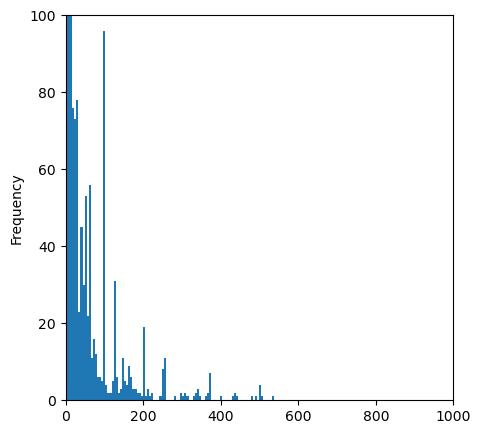

In [120]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1,1, figsize=(5,5))
average_MIC_unique_sequences.MIC_geometric_mean.plot.hist(bins=100, ax=ax)
ax.set_xlim([0,1000])
ax.set_ylim([0, 100])

In [122]:
avg_MIC_less_than_8196_2 = average_MIC_unique_sequences[average_MIC_unique_sequences.MIC_geometric_mean <= 8196//2]

## Results (sample counts)

In [123]:
print(f'There are {len(average_MIC_unique_sequences)} before MIC cutoff')
print(f'There are {len(avg_MIC_less_than_8196_2)} after filtering by MIC cutoff')
print(f'This is compared to the 1762 reported in the paper and 4,582 from the github repo for the paper')

There are 1737 before MIC cutoff
There are 1737 after filtering by MIC cutoff
This is compared to the 1762 reported in the paper and 4,582 from the github repo for the paper


In [125]:
average_MIC_unique_sequences.MIC_geometric_mean.describe()

count    1737.000000
mean       43.700667
std        72.047674
min         0.020000
25%         4.300000
50%        13.581954
75%        50.215495
max       536.456857
Name: MIC_geometric_mean, dtype: float64

## save positives

In [128]:
average_MIC_unique_sequences.rename(columns={'MIC_geometric_mean': 'MIC'})['MIC'].to_csv('July10th_FilteredGRAMPA.csv')